The expression **P + a * e**, where **P** is a point, **a** is a scalar (number), and **e** is a unit vector in some direction, indeed gives a point on a line going through **P** in the direction of **e**.

Here's why:

- **Point P**: Consider **P** as a position vector pointing from the origin to the location of **P** in space.
- **Unit Vector e**: A unit vector has a magnitude (length) of 1 and points in a specific direction. It essentially defines the direction of the line.
- **Scalar a**: Multiplying **e** by a scalar **a** scales the vector **e** by **a**. If **a** is positive, the direction of **e** is preserved, but its length is scaled by **a**. If **a** is negative, the direction is reversed, and its magnitude is scaled by the absolute value of **a**.

When you add **a * e** to **P**, you're moving from point **P** in the direction defined by **e**, by a distance proportional to **a**. This operation effectively traces out a line as **a** varies. The line is straight because **e** is constant (it always points in the same direction), and scaling **e** by **a** merely moves you farther or closer in that direction.

So, **P + a * e** describes a line in the direction of **e** passing through **P**. If you vary **a** across all real numbers, you'll trace every point on this line. This is a fundamental concept in vector algebra and geometry, often used to define lines in space.


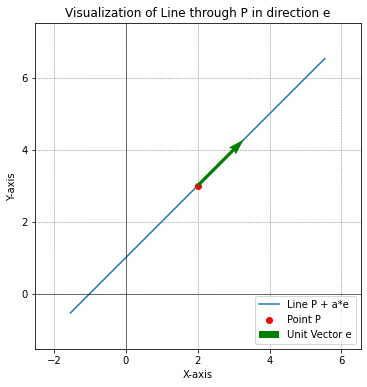

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the point P (e.g., [2, 3] in 2D space)
P = np.array([2, 3])

# Define a unit vector e in some direction (e.g., [1, 1] normalized)
e = np.array([1, 1]) / np.sqrt(2)  # Normalize to make it a unit vector

# Generate several scalar values (a) to show points on the line through P in direction e
a_values = np.linspace(-5, 5, 100)  # 100 points from -5 to 5

# Compute the points on the line P + a * e for all a_values
line_points = [P + a * e for a in a_values]

# Unzip the points to their x and y components for plotting
x_values, y_values = zip(*line_points)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='Line P + a*e')  # Plot the line
plt.scatter([P[0]], [P[1]], color='red', zorder=5, label='Point P')  # Mark point P
plt.quiver(*P, *e, scale=5, color='green', zorder=5, width=0.01, label='Unit Vector e')  # Show the direction of e

# Set an equal aspect ratio for the plot
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(min(x_values) - 1, max(x_values) + 1)
plt.ylim(min(y_values) - 1, max(y_values) + 1)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Visualization of Line through P in direction e')
plt.show()


In the context of PCA, the expression P + a * e can be seen as creating a new variable (the principal component) that is a linear combination of the original variables. Here, P would be the mean of the original variables, e would be the eigenvector (which defines the direction of the maximum variance), and a would be the corresponding eigenvalue (which defines the magnitude of the variance).